# Projet 2 : Concevez une application au service de la santé publique

## Filtering products and features

In [23]:
# Import libraries
import pandas as pd
import time
import os
import inspect
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pytesseract # Library to read text from image
import math 

import nltk
nltk.download('all')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\lepas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\lepas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\lepas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\lepas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\lepas\AppData\Roaming\nltk_data...
[nltk_data]    | 

In [2]:
# Useless in notebook

### GET DIRECTORIES ###
# Get full actual file path
actual_file_path = inspect.getframeinfo(inspect.currentframe()).filename
# Get parent folder path
path = os.path.dirname(os.path.abspath(actual_file_path))

In [3]:
# Import dataset. 
t1 = time.time()
df_raw = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/openfoodfacts_dataset.csv', header = 0, sep='\t' )

t2 = time.time()
#print(df_raw)

print(f'It took {t2-t1} sec to import the dataset')

C:\Users\lepas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,8,14,23,24,28,29,30,32,50,64,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


It took 41.58202338218689 sec to import the dataset


In [4]:
# Show all columns of the dataset
df_raw.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'packaging_en',
 'packaging_text',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'origins_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'ingredients_tags',
 'ingredients_analysis_tags',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'nutriscore_score',
 'nutriscore_grade',
 'nova_group',
 'pnns_groups_1',
 'pnns_groups

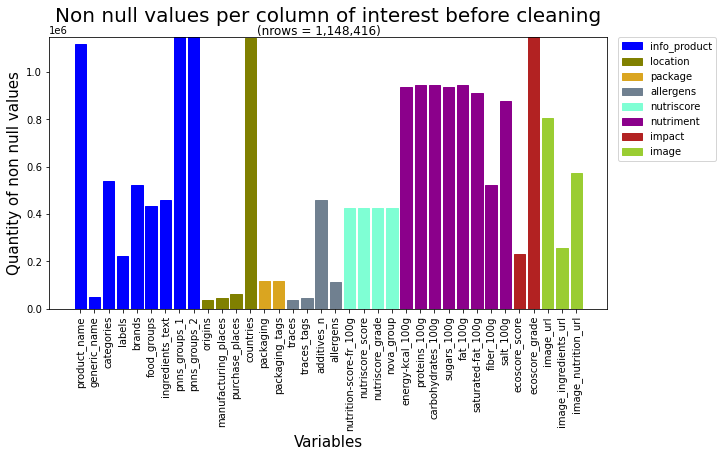

In [5]:

# =============================================================================
# Create a graph with variables of interest based on our needs
# =============================================================================

# List columns of interest
col_list = ['product_name', 'generic_name', 'categories','labels', 'brands', 'food_groups', 'ingredients_text', 'pnns_groups_1','pnns_groups_2',  # Info products
            'origins', 'manufacturing_places', 'purchase_places', 'countries', # Location
            'packaging', 'packaging_tags',# Composition packaging
            'traces', 'traces_tags', 'additives_n', 'allergens', # allergens and additives
            'nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade', 'nova_group', # nutriscore
            'energy-kcal_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'salt_100g', # Info composition
            'ecoscore_score', 'ecoscore_grade', # environmental impact
            'image_url', 'image_ingredients_url', 'image_nutrition_url' # Images
            ]

col_dict ={'info_product' : ['product_name', 'generic_name', 'categories','labels', 'brands', 'food_groups', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2'], # Info products
            'location': ['origins', 'manufacturing_places', 'purchase_places', 'countries'], # Location
            'package' : ['packaging', 'packaging_tags'], # Composition packaging
            'allergens' : ['traces', 'traces_tags', 'additives_n', 'allergens'], # allergens and additives
            'nutriscore' : ['nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade', 'nova_group'], # nutriscore
            'nutrient' : ['energy-kcal_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'salt_100g'], # Info composition
            'impact' : ['ecoscore_score', 'ecoscore_grade'], # environmental impact
            'image' : ['image_url', 'image_ingredients_url', 'image_nutrition_url'] # Images
            }

# Compute number of values available in each column.
available_values = df_raw[col_list].notnull().sum(axis=0)
#print(available_values)

plt.figure(figsize = (10,5))
plt.ticklabel_format(style='sci')

bars = plt.bar(col_list, available_values)
plt.title('Non null values per column of interest before cleaning',
          fontsize = 20, pad = 15)
plt.suptitle(f'(nrows = {len(df_raw):,d})', x = 0.5, y = 0.915)
plt.ylabel('Quantity of non null values', fontsize = 15)
plt.xlabel('Variables', fontsize = 15)
plt.xticks(rotation=90)
plt.ylim(0, len(df_raw))


# Change color of bars depending on their category

for n, bar in enumerate(bars):
    if col_list[n] in col_dict['info_product']:
        bar.set_color('blue')
        patch1 = mpatches.Patch(color='blue', label='info_product')
        
    if col_list[n] in col_dict['location']:
        bar.set_color('olive')    
        patch2 = mpatches.Patch(color='olive', label='location')
        
    if col_list[n] in col_dict['package']:
        bar.set_color('goldenrod')
        patch3 = mpatches.Patch(color='goldenrod', label='package')
        
    if col_list[n] in col_dict['allergens']:
        bar.set_color('slategrey')
        patch4 = mpatches.Patch(color='slategrey', label='allergens')
        
    if col_list[n] in col_dict['nutriscore']:
        bar.set_color('aquamarine')
        patch5 = mpatches.Patch(color='aquamarine', label='nutriscore')
        
    if col_list[n] in col_dict['nutrient']:
        bar.set_color('darkmagenta')    
        patch6 = mpatches.Patch(color='darkmagenta', label='nutriment')
        
    if col_list[n] in col_dict['impact']:
        bar.set_color('firebrick')    
        patch7 = mpatches.Patch(color='firebrick', label='impact')

    if col_list[n] in col_dict['image']:
        bar.set_color('yellowgreen')    
        patch8 = mpatches.Patch(color='yellowgreen', label='image')
        
plt.legend(handles=[patch1, patch2, patch3, patch4,
                    patch5, patch6, patch7, patch8],
           # loc = 'upper center')
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show();

In [6]:
# =============================================================================
# Remove data for products that are not available in France.
# =============================================================================

# Create a copy of our raw dataset to be able to work on it without modifying the original.
df_fr = df_raw.copy()

no_fr_list = []

for n, country in enumerate(df_fr['countries']):
    try:
        if "fr" in country or "Fr" in country or "FR" in country:
            pass
        else:
            no_fr_list.append(n)
        
    # Create this exception for when there is a nan value
    except TypeError:
        no_fr_list.append(n)


df_fr.drop(labels = no_fr_list, axis = 0, inplace = True)

# Since there are wrong labels in some cols, we change them to NaN.
df_fr.replace(to_replace = ('unknown', 'nan'), value = np.nan, inplace = True)

In [7]:
# =============================================================================
# Clean df using product_name and brands column.
# =============================================================================

# Remove duplicates
df_fr_no_dupl = df_fr.sort_values(by = 'ecoscore_score', ascending = True).drop_duplicates(subset = ['product_name', 'brands'], keep = 'first') 
               
# Remove products that have no product_name
df_fr_no_dupl_no_nan = df_fr_no_dupl[[x == True for x in df_fr_no_dupl['product_name'].notna()]]

# We reset the index of our df and give it a definitive name and keep only our variables of interest.
df = df_fr_no_dupl_no_nan[col_list].reset_index().copy()

print(f"""We have the following number of rows in our dfs:
    df_raw, Original dataset: {len(df_raw)}
    df_fr, Keeping only products available in France: {len(df_fr)}
    df_fr_no_dupl, Removing duplicates: {len(df_fr_no_dupl)}
    df_fr_no_dupl_no_nan, Removing products without a name: {len(df_fr_no_dupl_no_nan)}""")

We have the following number of rows in our dfs:
    df_raw, Original dataset: 1148416
    df_fr, Keeping only products available in France: 360840
    df_fr_no_dupl, Removing duplicates: 268567
    df_fr_no_dupl_no_nan, Removing products without a name: 267243


In [14]:

# =============================================================================
# Remove rows that are 90% empty (not counting product_name, countries and images)
# =============================================================================

col_list_nan = ['categories', 'brands', 'pnns_groups_1',  # Info products
            'packaging',# Composition packaging
            'nutriscore_score', 'nutriscore_grade', 'nova_group', # nutriscore
            'energy-kcal_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'salt_100g', # Info composition
            'ecoscore_score', 'ecoscore_grade', # environmental impact
            ]

df = df_fr_no_dupl_no_nan[col_list].reset_index().copy()

df_nan = df[col_list_nan]
# Consider that they are more than 90% valid entries
df_nan['p90'] = True

not_enough = []
p_90 = round((len(df_nan.columns))*0.9)
for n in tqdm(df.index):
    
    sum_empty = df_nan.loc[[n]].isna().sum().sum()
    if sum_empty > p_90:
        df_nan.loc[n, 'p90'] = False
        # not_enough.append(n)

## This is too long (several hours)
# # Drop not_enough rows
# not_enough = [*set(not_enough)]
# not_enough.sort(reverse=True)
# for prd in tqdm(not_enough):
#     df.drop(prd, axis = 'index', inplace=True)

## Therefore we change plans and use this simple way:
# Keep only the rows for which we have True
df = df[df_nan.p90]


df.reset_index(inplace = True)
df.drop('level_0', axis = 1, inplace=True)


# saving the dataframe
df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/sub_90_dataset.csv')

C:\Users\lepas\AppData\Local\Temp/ipykernel_23144/623603637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan['p90'] = True
100%|█████████████████████████████████████████████████████████████████████████| 267243/267243 [04:47<00:00, 928.74it/s]


## Dealing with outliers

In [15]:

# =============================================================================
# Remove all quantitative outliers from nutrients.
# =============================================================================

df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/sub_90_dataset.csv')

# Maximum energy in 100g is 900kcal
# From https://www.scientificamerican.com/article/how-do-food-manufacturers/
# We find that fat has the biggest coefficient with 9 kcal/g.
# So a product with 100% fat would be 900 kcal/g.
# We will use this maximum value for our analysis.
max_kcal = 900

# Maximum nutrient sum per 100g is 100g
max_nut = 100

# Maximum protein 72g: https://www.nutritionadvance.com/highest-protein-foods-per-100-grams/
max_prot = 72

# Max carbohydrate (sugar) and max fat are 100g so treated together at the end

# Max salt is 100 if salt. Otherwise, it is less than 20g : https://nutriments.monalimentation.org/sel.html
max_salt = 20
# Create counters to know how many outliers have been removed
c=0
t1 = time.time()

too_much = []

# Start by removing some outlier values based on their values
# Loop through df to remove outliers.
print("We are dealing with :")
for nutrient in col_dict['nutrient']:
    print('   - ',nutrient)
    
    for n, row_val in enumerate(tqdm(df[nutrient])):
        
        if nutrient == 'energy-kcal_100g':
            
            # If more than 5% error, remove row.
            if row_val > max_kcal*1.05:
                too_much.append(n)

            if row_val > max_kcal:
                df.loc[n, nutrient] = np.nan
                c+=1
                
            # Use the fact it is the first loop to compute sums 
            sum_nutrient = np.nansum(df.loc[n, 'proteins_100g'] +
                                df.loc[n, 'carbohydrates_100g'] +
                                df.loc[n, 'fat_100g'] + 
                                df.loc[n, 'fiber_100g'] +
                                df.loc[n, 'salt_100g'])
            
            # If more than 5% error, remove row.
            if sum_nutrient >= max_nut+1.05:
                too_much.append(n)
            
            elif sum_nutrient > max_nut:
                # print(df.loc[n, 'product_name'], sum_nutrient)
                df.loc[n, 'proteins_100g'] = np.nan
                df.loc[n, 'carbohydrates_100g'] = np.nan
                df.loc[n, 'fat_100g'] = np.nan 
                df.loc[n, 'fiber_100g'] = np.nan
                df.loc[n, 'salt_100g'] = np.nan
                c+=1
            
        else:  
            # Looking at proteins
            if nutrient == 'proteins_100g':
                # There is no food with more than 72g of proteins per 100g
                if row_val >= max_prot*1.05:
                    too_much.append(n)
                    
                elif row_val > max_prot:
                    df.loc[n, nutrient] = np.nan
                    c+=1
            
            # Looking at salt
            elif nutrient == 'salt_100g':
                # There is no food with more than 20g of salt per 100g except for salt
                s_name = df.loc[n, 'product_name']
                # Check if we are not dealing with actual salt
                if 'sel' in s_name or 'Sel' in s_name:
                    pass
                else:
                    if row_val >= max_salt*1.05:
                        too_much.append(n)
                        
                    elif row_val > max_salt:
                        df.loc[n, nutrient] = np.nan
                        c+=1
            
            elif nutrient == 'sugars_100g':
                if df.loc[n, 'carbohydrates_100g'] is not np.nan:
                    # Sugars are counted in carbohydrates so its amount should be inferior 
                    # than the latter
                    if row_val > df.loc[n, 'carbohydrates_100g']*1.05:
                        too_much.append(n)
                        
                    elif row_val > df.loc[n, 'carbohydrates_100g']:
                        df.loc[n, nutrient] = np.nan
                        c+=1
                else:
                    df.loc[n, nutrient] = np.nan
                    c+=1
            
            elif nutrient == 'saturated-fat_100g':
                
                if df.loc[n, 'fat_100g'] is not np.nan:
                    # Saturated fat are counted in fat so its amount should be inferior 
                    # than the latter
                    if row_val > df.loc[n, 'fat_100g']*1.05:
                        too_much.append(n)
                        
                    elif row_val > df.loc[n, 'fat_100g']:
                        df.loc[n, nutrient] = np.nan
                        c+=1
                else:
                    df.loc[n, nutrient] = np.nan
                    c+=1
                    
            # Finally, remove all values that are below 0 or above 100 since 
            # you cannot have more grams of nutrient than g of product.
            if row_val < 0 or row_val >= 100*1.05:
                too_much.append(n)
                
            elif row_val > 100:
                df.loc[n, nutrient] = np.nan
                c+=1
                
                
t2 = time.time()

print('')
print(f'We remove {len(too_much)} outliers in this phase')
print(f'{c} values were changed to np.nan')


# Drop too_much rows
too_much = [*set(too_much)]
too_much.sort(reverse=True)
for prd in tqdm(too_much):
    df.drop(prd, axis = 'index', inplace=True)

df.reset_index(inplace = True)
df.drop('level_0', axis = 1, inplace=True)


# saving the dataframe
df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/nan_dataset.csv')


We are dealing with :
   -  energy-kcal_100g


100%|███████████████████████████████████████████████████████████████████████| 248860/248860 [00:21<00:00, 11530.46it/s]


   -  proteins_100g


100%|██████████████████████████████████████████████████████████████████████| 248860/248860 [00:00<00:00, 466777.79it/s]


   -  carbohydrates_100g


100%|██████████████████████████████████████████████████████████████████████| 248860/248860 [00:00<00:00, 914730.58it/s]


   -  sugars_100g


100%|███████████████████████████████████████████████████████████████████████| 248860/248860 [00:05<00:00, 43781.32it/s]


   -  fat_100g


100%|█████████████████████████████████████████████████████████████████████| 248860/248860 [00:00<00:00, 1130932.87it/s]


   -  saturated-fat_100g


100%|███████████████████████████████████████████████████████████████████████| 248860/248860 [00:09<00:00, 27294.69it/s]


   -  fiber_100g


100%|█████████████████████████████████████████████████████████████████████| 248860/248860 [00:00<00:00, 1501413.24it/s]


   -  salt_100g


100%|██████████████████████████████████████████████████████████████████████| 248860/248860 [00:02<00:00, 122984.64it/s]



We remove 3243 outliers in this phase
1362 values were changed to np.nan


100%|██████████████████████████████████████████████████████████████████████████████| 3108/3108 [07:27<00:00,  6.94it/s]


Since there are some products that should not be there (like Harry Potter figurines or Lady Gaga vinyl), we use another dataset that will help us clean all that.

In [16]:

# =============================================================================
# Import new dataset, made by professionals, that contains food
# =============================================================================

# Import datase'
df_ciqual = pd.read_excel('D:/stuffs/Online_courses/openclassrooms/Projet2/data/Table Ciqual 2020_FR_2020 07 07.xls')
df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/nan_dataset.csv')

print("Creating a corpus from another dataset...")

# Only keep column of interest
df_ciqual = df_ciqual['alim_nom_fr']

# Remove text that is in between brackets
for n, m in enumerate(df_ciqual):
    df_ciqual[n] = re.sub("\(.*?\)","", m)


# create a list text
text = list(df_ciqual)

# preprocessing loop
lemmatizer = WordNetLemmatizer()

corpus_ciqual = []
for i in tqdm(range(len(text))):
    r = unidecode(text[i])
    r = re.sub('[^a-zA-Z]', ' ', r)
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('french')
         and len(word) > 2]
    r = [lemmatizer.lemmatize(word) for word in r]
    # If word not already in corpus, add it. 
    for word in r:
        if word not in corpus_ciqual:
            corpus_ciqual.append(word)

# print(corpus_ciqual)


# =============================================================================
# If product_name not in corpus_name, remove row.
# (Avoid having products like "Scrabble Classique", "Tosma", "Lady Gaga - Chromatica K7 Rose", "Harry Potter 83 Ritka Skeeter")
# =============================================================================

print("Creating a corpus from our dataset...")

df_lem = df.copy()

# create a list text
text = list(df_lem['product_name'])

# preprocessing loop
lemmatizer = WordNetLemmatizer()

corpus = []
for i in tqdm(range(len(text))):
    r = unidecode(text[i])
    r = re.sub('[^a-zA-Z]', ' ', r)
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('french')
         and len(word) > 2]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

#assign corpus to the product_name column
df_lem['product_name'] = corpus


print("Comparing both corpora...")

to_remove = []

for n, prd in enumerate(tqdm(df_lem['product_name'])):
    count = 0
    words = prd.split(" ")

    for word in words:
        res = any(word[:-1] in sub for sub in corpus_ciqual)
        if res:
            count +=1
    
    
    if count/len(words) < 0.51:
        to_remove.append(n)
    
print("Removing rows from our corpus that are not in the other...")
# Remove them
to_remove.reverse()
for prd in tqdm(to_remove):
    df.drop(prd, axis = 'index', inplace=True)

df.reset_index(inplace = True)
df.drop('level_0', axis = 1, inplace=True)

# saving the dataframe
df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/new_nan_dataset.csv')

Creating a corpus from another dataset...


100%|█████████████████████████████████████████████████████████████████████████████| 3186/3186 [00:04<00:00, 762.21it/s]


Creating a corpus from our dataset...


100%|████████████████████████████████████████████████████████████████████████| 245752/245752 [02:28<00:00, 1657.48it/s]


Comparing both corpora...


100%|████████████████████████████████████████████████████████████████████████| 245752/245752 [01:21<00:00, 2999.13it/s]


Removing rows from our corpus that are not in the other...


100%|██████████████████████████████████████████████████████████████████████████| 62592/62592 [1:48:17<00:00,  9.63it/s]


Re-draw graphs with maximum nan values

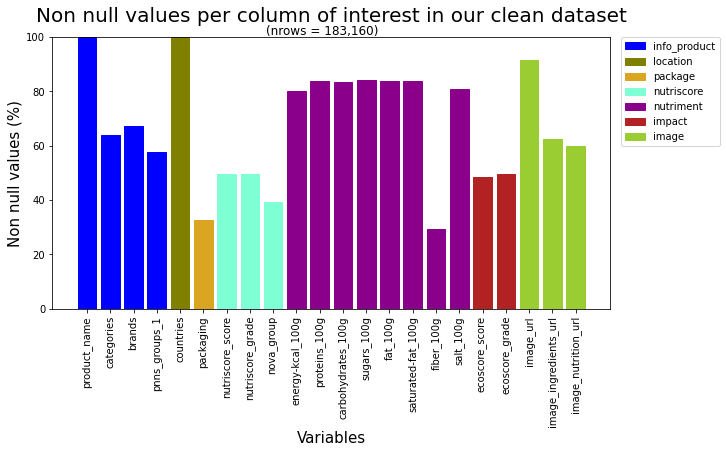

In [17]:

# =============================================================================
# We re-draw our graph with our cleaned dataset
# =============================================================================

# Import dataset
df = pd.read_csv("D:/stuffs/Online_courses/openclassrooms/Projet2/data/new_nan_dataset.csv")

col_list = ['product_name', 'categories',  'brands', 'pnns_groups_1',  # Info products
            'countries', # Location
            'packaging',# Composition packaging
            'nutriscore_score', 'nutriscore_grade', 'nova_group', # nutriscore
            'energy-kcal_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'salt_100g', # Info composition
            'ecoscore_score', 'ecoscore_grade', # environmental impact
            'image_url', 'image_ingredients_url', 'image_nutrition_url' # Images
            ]

col_dict ={'info_product' : ['product_name', 'categories', 'brands', 'pnns_groups_1'], # Info products
           'location': ['countries'], # Location
           'package' : ['packaging'], # Composition packaging
           'nutriscore' : ['nutriscore_score', 'nutriscore_grade', 'nova_group'], # nutriscore
           'nutrient' : ['energy-kcal_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'fiber_100g', 'salt_100g'], # Info composition
           'impact' : ['ecoscore_score', 'ecoscore_grade'], # environmental impact
           'image' : ['image_url', 'image_ingredients_url', 'image_nutrition_url'] # Images
           }

available_values = df[col_list].notnull().sum(axis=0)

plt.figure(figsize = (10,5))
plt.ticklabel_format(style='sci')

# Use percentage in the y axis instead of plain values
bars = plt.bar(col_list, available_values/len(df)*100)
plt.title('Non null values per column of interest in our clean dataset',
          fontsize = 20, pad = 15)
plt.suptitle(f'(nrows = {len(df):,d})', x = 0.5, y = 0.915)
plt.ylabel('Non null values (%)', fontsize = 15)
plt.xlabel('Variables', fontsize = 15)
plt.xticks(rotation=90)
plt.ylim(0,100)


# Change color of bars depending on their category
for n, bar in enumerate(bars):
    if col_list[n] in col_dict['info_product']:
        bar.set_color('blue')
        patch1 = mpatches.Patch(color='blue', label='info_product')
        
    if col_list[n] in col_dict['location']:
        bar.set_color('olive')    
        patch2 = mpatches.Patch(color='olive', label='location')
        
    if col_list[n] in col_dict['package']:
        bar.set_color('goldenrod')
        patch3 = mpatches.Patch(color='goldenrod', label='package')
        
    if col_list[n] in col_dict['nutriscore']:
        bar.set_color('aquamarine')
        patch5 = mpatches.Patch(color='aquamarine', label='nutriscore')
        
    if col_list[n] in col_dict['nutrient']:
        bar.set_color('darkmagenta')    
        patch6 = mpatches.Patch(color='darkmagenta', label='nutriment')
        
    if col_list[n] in col_dict['impact']:
        bar.set_color('firebrick')    
        patch7 = mpatches.Patch(color='firebrick', label='impact')
        
    if col_list[n] in col_dict['image']:
        bar.set_color('yellowgreen')    
        patch8 = mpatches.Patch(color='yellowgreen', label='image')

plt.legend(handles=[patch1, patch2, patch3, #patch4, 
                    patch5, patch6, patch7, patch8],
            bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()



## Fill missing values

Start by importing the dataset

In [18]:

# Import dataset. 
t1 = time.time()
df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/new_nan_dataset.csv', header = 0 )

# Change 'nan' to np.nan
# df.replace('nan', np.nan)


t2 = time.time()
print(df)

print(f'It took {t2-t1} sec to import the dataset')


        Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1    index  \
0                0             2               2  1076159   
1                1             3               3    73202   
2                2             5               5  1115835   
3                3             7               7  1068103   
4                4             8               8  1101219   
...            ...           ...             ...      ...   
183155      183155        245744          248852  1148408   
183156      183156        245746          248854  1148410   
183157      183157        245749          248857  1148413   
183158      183158        245750          248858  1148414   
183159      183159        245751          248859  1148415   

                               product_name  \
0                Cappuccino Saveur Chocolat   
1       Mexican hot chocolate drink tablets   
2           Moussaka à la Crétoise, Surgelé   
3                Dosettes de café Equilibré   
4                    Café solubl

Start by increasing the number of pnns_groups_1. That will be useful for further analysis.

In [21]:

# =============================================================================
# Use linear regression to increase pnns_groups_1 number of data.
# =============================================================================
# https://www.datacamp.com/tutorial/text-classification-python


# text preprocessing
df_text = df.copy()

# create a list text
text = list(df_text['product_name'])


# preprocessing loop
lemmatizer = WordNetLemmatizer()

corpus = []
for i in tqdm(range(len(text))):
    r = unidecode(text[i])
    r = re.sub('[^a-zA-Z]', ' ', r)
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('french') and len(word) > 2]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

#assign corpus to the product_name column
df_text['product_name'] = corpus

#%%

print("Adding pnns values...")

# Create Feature and Label sets
X =  df_text['product_name'][df_text['pnns_groups_1'].notna()]
y = df_text['pnns_groups_1'][df_text['pnns_groups_1'].notna()]
seed=42


# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=seed)

# Create Bag of Words model
cv = CountVectorizer(analyzer='word')

# Train Bag of Words model/Transorm words data to nb
X_train_cv = cv.fit_transform(X_train)


# Create logistic regression
lr = LogisticRegression(max_iter = 1000)

# Train model
lr.fit(X_train_cv, y_train)


# transform X_test using CV
X_test_cv = cv.transform(X_test)


# generate predictions
predictions = lr.predict(X_test_cv)

# Compute score of the model
score_lr = lr.score(X_test_cv, y_test)

print(f'\nThe model used here has a score of {score_lr} on the testing set.\n')


# We go on predicting our missing values.
# Get a sub df for prediction purpose
X_predict = pd.DataFrame(df_text['product_name'].dropna())

X_temp = X_predict.merge(X, how='left', left_index = True, right_index = True,
            indicator=True)

X_predict = (X_predict[X_temp['_merge'] == 'left_only']).squeeze()


# Predict output 
X_predict_cv = cv.transform(X_predict)
y_predict = pd.Series(lr.predict(X_predict_cv))


X_predict = pd.DataFrame(X_predict)

# Add new index column 
X_predict['new_index'] = range(len(X_predict.index))

# X_predict = pd.DataFrame(X_predict)
X_y = pd.DataFrame()
# Merge output and input
X_y = X_predict.merge(y_predict.rename('pnns_predict'),
                      how='inner', left_on = 'new_index', right_index = True)

# Add the product groups and name
X_y = X_y.merge(df_text[['pnns_groups_1', 'product_name']],
                how='inner', left_on = 'new_index', right_index = True)


 
for n, x in enumerate(tqdm(df_text['product_name'])):
    
    ori = df_text.loc[n,'pnns_groups_1']
    
    #Check if we originally have a value for the nutriscore grade
    if ori is np.nan: # Here we use np.nan because we have strings.
        # Check if we have a new value to use
        try:
            new = (X_y.loc[n, 'pnns_predict'])
            # If we have a computed value, use it
            df_text.loc[n,'pnns_groups_1'] = new
            
        except KeyError:
            pass
        
df['pnns_groups_1'] = df_text['pnns_groups_1']    
        

# saving the dataframe
df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns.csv')

100%|████████████████████████████████████████████████████████████████████████| 183160/183160 [02:25<00:00, 1262.60it/s]


Adding pnns values...

The model used here has a score of 0.9054573040633446 on the testing set.



100%|█████████████████████████████████████████████████████████████████████████| 183160/183160 [03:40<00:00, 830.18it/s]


In [25]:

# =============================================================================
# Fill in nutrients
# =============================================================================

# https://www.livestrong.com/article/312047-how-to-calculate-energy-from-foods/
# The computation is as follow:
  # energy (kcal/g) = 9 * fat (g/100g) + 4 * proteins (g/100g) + 4 * carbohydrates (g/100g)

# Import df
df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns.csv')

print("Adding some nutrient values based on a simple computation...")
print("(energy (kcal/g) = 9 * fat (g/100g) + 4 * proteins (g/100g) + 4 * carbohydrates (g/100g))")

max_kcal = 900
max_prot = 72
max_carbs = 100
max_fat = 100

c = 0

to_remove = []
for n, kcal in enumerate(tqdm(df['energy-kcal_100g'])):
    
    fat = df.loc[n, 'fat_100g']
    prot = df.loc[n, 'proteins_100g']
    carbs = df.loc[n, 'carbohydrates_100g']
    
    kcal_nan = math.isnan(kcal)
    fat_nan = math.isnan(fat)
    prot_nan = math.isnan(prot)
    carbs_nan = math.isnan(carbs)

    # Compute kcal
    if kcal_nan and not fat_nan and not prot_nan and not carbs_nan:
        new_kcal = int(9 * fat + 4 * prot + 4 * carbs)
        if new_kcal <= max_kcal and new_kcal >= 0:
            df.loc[n, 'energy-kcal_100g'] = new_kcal
            c+=1
        else:
            to_remove.append(n)
        
    # Compute fat
    if fat_nan and not kcal_nan and not prot_nan and not carbs_nan:
        new_fat= int((kcal - (4 * prot + 4 * carbs))/9)
        if new_fat <= max_fat and new_fat >= 0:
            df.loc[n, 'fat_100g'] = new_fat
            c+=1
        else:
            to_remove.append(n)
        
        
    # Compute proteins
    if prot_nan and not kcal_nan and not fat_nan and not carbs_nan:
        new_prot = int((kcal - (9 * fat + 4 * carbs))/4)
        if new_prot <= max_prot and new_prot >= 0:
            df.loc[n, 'proteins_100g'] = new_prot
            c+=1
        else:
            to_remove.append(n)
            
            
    # Compute carbohydrates
    if carbs_nan and not kcal_nan and not fat_nan and not prot_nan:
        new_carbs = int((kcal - (9 * fat + 4 * prot))/4)
        if new_carbs <= max_carbs and new_carbs >= 0:
            df.loc[n, 'carbohydrates_100g'] = new_carbs
            c+=1
        else:
            to_remove.append(n)
            

print(c)

print(f"""
      Helped on adding {c} values in the nutrients columns.
      Have to remove {len(to_remove)} more rows.
      """)

# Drop to_remove rows
to_remove = [*set(to_remove)]
to_remove.sort(reverse=True)
for prd in tqdm(to_remove):
    df.drop(prd, axis = 'index', inplace=True)

df.reset_index(inplace = True)
df.drop('level_0', axis = 1, inplace=True)



Adding some nutrient values based on a simple computation...
(energy (kcal/g) = 9 * fat (g/100g) + 4 * proteins (g/100g) + 4 * carbohydrates (g/100g))


100%|███████████████████████████████████████████████████████████████████████| 183160/183160 [00:17<00:00, 10311.75it/s]


8241

      Helped on adding 8241 values in the nutrients columns.
      Have to remove 54 more rows.
      


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00,  9.84it/s]


In [26]:

# =============================================================================
# Working on fibers.
# Using the median value of category
# (7mn)
# =============================================================================

print('Adding fiber values...')

t1 = time.time()
c = 0
cat_dict = {}


for n, row_val in enumerate(tqdm(df['fiber_100g'])):
    # Get the categroy of the product
    cat_prd = df.loc[n, 'pnns_groups_1']
    
    if cat_prd not in cat_dict.keys() and cat_prd is not np.nan:
        # Create df with only the category products
        category_df = df[df['pnns_groups_1'] == cat_prd]
        # Compute average value per category
        avrg = np.nanmedian(category_df['fiber_100g'])
        # Put them in the dict
        cat_dict[cat_prd] = round(avrg, 1)
    
    # Check if category exists and if fiber is nan
    if math.isnan(row_val) and cat_prd is not np.nan:
        df.loc[n, 'fiber_100g'] = cat_dict[cat_prd]
        c+=1
        
t2 = time.time()

print("\n\n")
print(f"There has been {c} values added in the fiber column.")
print(f"It took {(t2-t1)/60} mn to iterate through the df")



Adding fiber values...


 52%|█████████████████████████████████████▋                                   | 94682/183106 [01:27<01:22, 1070.68it/s]C:\Users\lepas\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|█████████████████████████████████████████████████████████████████████████| 183106/183106 [03:03<00:00, 997.73it/s]




There has been 129442 values added in the fiber column.
It took 3.0587722341219585 mn to iterate through the df


In [27]:

# =============================================================================
# Fill in nutrients
# =============================================================================

# https://www.livestrong.com/article/312047-how-to-calculate-energy-from-foods/
# The computation is as follow:
  # energy (kcal/g) = 9 * fat (g/100g) + 4 * proteins (g/100g) + 4 * carbohydrates (g/100g)

max_kcal = 900
max_prot = 72
max_carbs = 100
max_fat = 100

c = 0

to_remove = []
for n, kcal in enumerate(tqdm(df['energy-kcal_100g'])):
    
    fat = df.loc[n, 'fat_100g']
    prot = df.loc[n, 'proteins_100g']
    carbs = df.loc[n, 'carbohydrates_100g']
    
    kcal_nan = math.isnan(kcal)
    fat_nan = math.isnan(fat)
    prot_nan = math.isnan(prot)
    carbs_nan = math.isnan(carbs)

    # Compute kcal
    if kcal_nan and not fat_nan and not prot_nan and not carbs_nan:
        new_kcal = int(9 * fat + 4 * prot + 4 * carbs)
        if new_kcal <= max_kcal:
            df.loc[n, 'energy-kcal_100g'] = new_kcal
            c+=1
        else:
            to_remove.append(n)
        
    # Compute fat
    if fat_nan and not kcal_nan and not prot_nan and not carbs_nan:
        new_fat= int((kcal - (4 * prot + 4 * carbs))/9)
        if new_fat <= max_fat:
            df.loc[n, 'fat_100g'] = new_fat
            c+=1
        else:
            to_remove.append(n)
        
        
    # Compute proteins
    if prot_nan and not kcal_nan and not fat_nan and not carbs_nan:
        new_prot = int((kcal - (9 * fat + 4 * carbs))/4)
        if new_prot <= max_prot:
            df.loc[n, 'proteins_100g'] = new_prot
            c+=1
        else:
            to_remove.append(n)
            
            
    # Compute carbohydrates
    if carbs_nan and not kcal_nan and not fat_nan and not prot_nan:
        new_carbs = int((kcal - (9 * fat + 4 * prot))/4)
        if new_carbs <= max_carbs:
            df.loc[n, 'carbohydrates_100g'] = new_carbs
            c+=1
        else:
            to_remove.append(n)
            

print(c)

print(f"""
      Helped on adding {c} values in the nutrients columns.
      Have to remove {len(to_remove)} more rows.
      """)

# Drop to_remove rows
to_remove = [*set(to_remove)]
to_remove.sort(reverse=True)
for prd in tqdm(to_remove):
    df.drop(prd, axis = 'index', inplace=True)

df.reset_index(inplace = True)
df.drop('level_0', axis = 1, inplace=True)

100%|███████████████████████████████████████████████████████████████████████| 183106/183106 [00:04<00:00, 45214.15it/s]


0

      Helped on adding 0 values in the nutrients columns.
      Have to remove 0 more rows.
      


0it [00:00, ?it/s]


At this point, we cannot add values for salt_100g except by using an IterativeImputer. Basically, the InterativeImputer add values in a column based on a certain logic that it has but there is no way to score it. Therefore, I chose not to use it in Mmy analysis.

In [28]:

# =============================================================================
# Remove rows with nan values looking at nutrients because we have no
# ways to add salt values and remain consistent.
# =============================================================================

df_nut = df[col_dict['nutrient']].dropna(how = 'any', axis = 0)

df_temp = df.merge(df_nut, how='left', left_index = True, right_index = True, indicator=True)
    
df_nut = (df[df_temp['_merge'] == 'both']).squeeze()

# saving the dataframe
df_nut.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns_nut.csv')


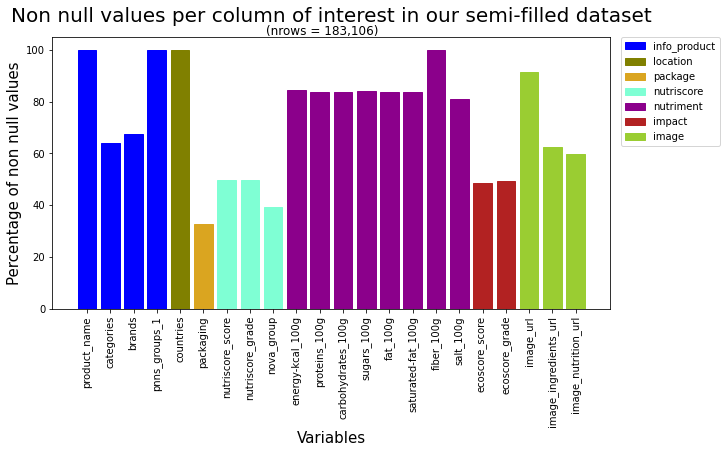

In [29]:

# =============================================================================
# We draw our graph with our semi-filled dataset
# =============================================================================

# df = pd.read_csv(path + "/data/dataset_pnns_nut.csv")


available_values = df[col_list].notnull().sum(axis=0)

plt.figure(figsize = (10,5))
plt.ticklabel_format(style='sci')

# Use percentage in the y axis instead of plain values
bars = plt.bar(col_list, available_values/len(df)*100)
plt.title('Non null values per column of interest in our semi-filled dataset',
          fontsize = 20, pad = 15)
plt.suptitle(f'(nrows = {len(df):,d})', x = 0.5, y = 0.915)
plt.ylabel('Percentage of non null values', fontsize = 15)
plt.xlabel('Variables', fontsize = 15)
plt.xticks(rotation=90)
# plt.ylim(0,100)


# Change color of bars depending on their category
for n, bar in enumerate(bars):
    if col_list[n] in col_dict['info_product']:
        bar.set_color('blue')
        patch1 = mpatches.Patch(color='blue', label='info_product')
        
    if col_list[n] in col_dict['location']:
        bar.set_color('olive')    
        patch2 = mpatches.Patch(color='olive', label='location')
        
    if col_list[n] in col_dict['package']:
        bar.set_color('goldenrod')
        patch3 = mpatches.Patch(color='goldenrod', label='package')
        
    # if col_list[n] in col_dict['allergens']:
    #     bar.set_color('slategrey')
    #     patch4 = mpatches.Patch(color='slategrey', label='allergens')
        
    if col_list[n] in col_dict['nutriscore']:
        bar.set_color('aquamarine')
        patch5 = mpatches.Patch(color='aquamarine', label='nutriscore')
        
    if col_list[n] in col_dict['nutrient']:
        bar.set_color('darkmagenta')    
        patch6 = mpatches.Patch(color='darkmagenta', label='nutriment')
        
    if col_list[n] in col_dict['impact']:
        bar.set_color('firebrick')    
        patch7 = mpatches.Patch(color='firebrick', label='impact')
        
    if col_list[n] in col_dict['image']:
        bar.set_color('yellowgreen')    
        patch8 = mpatches.Patch(color='yellowgreen', label='image')

plt.legend(handles=[patch1, patch2, patch3, #patch4, 
                    patch5, patch6, patch7, patch8],
           # loc = "upper center")
            bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Use a knn to compute missing values for the nutriscore.


Computing knn for nutriscore...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


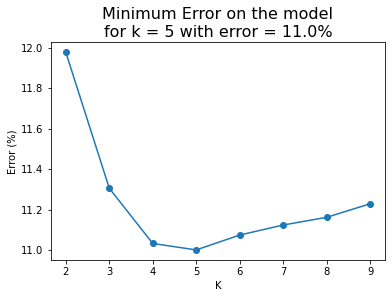

It took 3.37176775932312 s to run the knn.

We get a minimum error of 11.0% with a regressor on nutrition score with k=5.

Predicting nutriscore values...

Getting nutriscore grade from nutriscore score...


100%|██████████████████████████████████████████████████████████████████████████| 54711/54711 [00:12<00:00, 4423.22it/s]



Putting computed results into df...


100%|█████████████████████████████████████████████████████████████████████████| 145053/145053 [03:00<00:00, 803.75it/s]


In [30]:

# =============================================================================
# Working on nutriscore grade.
# Compute KNN-regressor
# =============================================================================

from sklearn.model_selection import train_test_split
from sklearn import neighbors
# import random

df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2//data/dataset_pnns_nut.csv')


print("Computing knn for nutriscore...")

# Get a sub df with col of interest
X = df[['nutriscore_score', # Here is the desired output
        'proteins_100g', 'fiber_100g', # Supposed to have a lot of those
        'energy-kcal_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g'# Suppose to limit those
    ]].dropna().copy()


# Attribute our output to a pd.Series()
y = X['nutriscore_score']
# Drop the output from the sub df 
X.drop('nutriscore_score', axis=1, inplace = True)

# Use a seed for reproducibility
seed = 42

# Split df in train and test set
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, 
                                                random_state = seed)

t1 = time.time()

# We try our model with several k values.
errors = []
max_k = 10
min_k = 2

for k in tqdm(range(min_k,max_k)):
    # print(k, '/',max_k)
    # Create Classifier model
    # knn = neighbors.KNeighborsClassifier(k, weights = 'uniform')
    
    # Create Regressor model
    knn = neighbors.KNeighborsRegressor(k, weights = 'uniform')
    
    # Train model AND compute score (or error) of the model on testing set
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))


# We search for the index (therefore k-min_k) of the minimum error
temp = min(errors)
res = [i for i, j in enumerate(errors) if j == temp][0] + min_k

# Draw figure of the result
plt.figure()
plt.plot(range(min_k,max_k), errors, 'o-')
plt.title(f'Minimum Error on the model\nfor k = {res} with error = {round(temp, 2)}%', 
                fontsize = 16)
plt.ylabel('Error (%)')
plt.xlabel('K')
plt.show()

t2 = time.time()

print(f'It took {t2-t1} s to run the knn.')
print("")
print(f"We get a minimum error of {round(temp, 2)}% with a regressor on nutrition score with k={res}.")

# Add product_name to our df to remove duplicates later.
# X = X.merge(df['product_name'], how='inner', left_index = True, right_index = True)


print("\nPredicting nutriscore values...")
# Get a sub df for prediction purpose
X_predict = df[['proteins_100g', 'fiber_100g', # Supposed to have a lot of those
        'energy-kcal_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g'# Suppose to limit those
    ]].dropna()

# X_predict=df.copy()

X_temp = X_predict.merge(X, how='left', left_index = True, right_index = True,
            indicator=True)

X_predict = X_predict[X_temp['_merge'] == 'left_only']

# Recreate best Regressor model
knn = neighbors.KNeighborsRegressor(res, weights = 'uniform')

# Train model
knn.fit(xtrain, ytrain)

# Predict output 
y_predict = pd.Series(knn.predict(X_predict))

# Add new index column 
X_predict['new_index'] = range(len(X_predict.index))

# Merge output and input
X_y = X_predict.merge(y_predict.rename('nutri_score_predict'),
                      how='inner', left_on = 'new_index', right_index = True)

# Add the product groups and name
X_y = X_y.merge(df[['pnns_groups_1', 'product_name']],
                how='inner', left_on = 'new_index', right_index = True)

print("\nGetting nutriscore grade from nutriscore score...")
# Here we find the translation score to grade (page 23/35)
# file:///C:/Users/lepas/Downloads/Nutriscore_reglement_usage_FR_310122_VDEF.pdf
nutri_grade_predict = []
for i, n in enumerate(tqdm(X_y['nutri_score_predict'])):
    #  There are not the same thresholds depending on if it's beverages or not.
    
    if  'Beverages' in X_y.loc[X_y['new_index']==i, 'pnns_groups_1']:
    
        if 'water' in X_y.loc[i, 'product_name']:
            nutri_grade_predict.append('a')
        
        elif round(n) <= 1:
            nutri_grade_predict.append('b')
    
        elif round(n) <= 5:
            nutri_grade_predict.append('c')
            
        elif round(n) <= 9:
            nutri_grade_predict.append('d')
            
        else:
            nutri_grade_predict.append('e')
        

    else:
        if round(n) <= -1:
            nutri_grade_predict.append('a')
        
        elif round(n) <= 2:
            nutri_grade_predict.append('b')
    
        elif round(n) <= 10:
            nutri_grade_predict.append('c')
            
        elif round(n) <= 18:
            nutri_grade_predict.append('d')
            
        else:
            nutri_grade_predict.append('e')

X_y['nutri_grade_predict'] = nutri_grade_predict


# =============================================================================
# Insert results into df
# =============================================================================

# Add the product groups and name
# df_nutri = df.merge(X_y['nutri_grade_predict'],
#                 how='left', left_on = df['product_name'], right_on = X_y['product_name'])

# df_nutri.drop_duplicates(subset=['product_name', 'brands'], inplace=True)

print("\nPutting computed results into df...")

df_nutri = df.copy()
X_y.drop_duplicates('product_name')
    
    
for n, x in enumerate(tqdm(df_nutri['product_name'])):
    
    ori_gr = df_nutri.loc[n,'nutriscore_grade']
    ori_sc = df_nutri.loc[n,'nutriscore_score']
    
    #Check if we originally have a value for the nutriscore grade
    if ori_gr is np.nan: # Here we use np.nan because we have strings.
        # Check if we have a new value to use
        try:
            new_gr = (X_y.loc[n, 'nutri_grade_predict'])

            # If we have a computed value, use it
            df_nutri.loc[n,'nutriscore_grade'] = new_gr[0]
            
        except KeyError:
            pass
        
    
    #Check if we originally have a value for the nutriscore score
    if math.isnan(ori_sc): # Here we use math.isnan() because we have floats.
        # Check if we have a new value to use
        try:
            new_sc = (X_y.loc[n, 'nutri_score_predict'])

            # If we have a computed value, use it
            df_nutri.loc[n,'nutriscore_score'] = new_sc
            
        except KeyError:
            pass

        
# saving the dataframe
df_nutri.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns_nut_nutrisc.csv')


Use linear regression to add values to nova.

In [31]:

# =============================================================================
# Compute missing values on nova 
# =============================================================================

df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns_nut_nutrisc.csv', header = 0)

seed = 42

print("\nAdding all the remaining missing values in nova...")


for group in tqdm(df['pnns_groups_1'].unique()):
    print('\nWorking on: ', group, '\n')
    # Create train/test table.
    df_group = df[df['pnns_groups_1'] == group]
    df_nova = df_group[col_dict['nutrient']].join(df_group.nova_group).dropna(how = 'any', axis = 0)
    
    # Create prediction table
    df_temp = df_group.merge(df_nova, how='left', left_index = True, right_index = True,
                indicator=True)
    
    X_predict = (df_group[df_temp['_merge'] == 'left_only']).squeeze()
    
    
    # Create Feature and Label sets
    X = df_nova[col_dict['nutrient']]
    y = df_nova.nova_group

    # train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                        random_state=seed)

    # Create logistic regression
    lr = LogisticRegression(max_iter = 10000)

    # Train model
    lr.fit(X_train, y_train)

    # # generate predictions
    # predictions = lr.predict(X_test_cv)

    # Compute score of the model
    score_lr = lr.score(X_test, y_test)
    print('Obtained a score of: ', score_lr, '\n')
    
    
    # We go on predicting our missing values.
    # Get a sub df for prediction purpose
    X_predict = df_group[col_dict['nutrient']]
    
    X_temp = X_predict.merge(X, how='left', left_index = True, right_index = True,
                indicator=True)

    X_predict = (X_predict[X_temp['_merge'] == 'left_only']).squeeze()

    # Keep only right cols
    # X_predict = X_predict[col_dict['nutrient']]
    
    # Predict output 
    y_predict = pd.Series(lr.predict(X_predict))
    
    # Turn it back to df
    X_predict = pd.DataFrame(X_predict)

    # Add new index column 
    X_predict['new_index'] = range(len(X_predict.index))

    # X_predict = pd.DataFrame(X_predict)
    X_y = pd.DataFrame()
    
    # Merge output and input
    X_y = X_predict.merge(y_predict.rename('nova_predict'),
                          how='inner', left_on = 'new_index', right_index = True)

    # # Add the product groups and name
    # X_y = X_y.merge(df_nova[col_dict['nutrient']],
    #                 how='inner', left_on = 'new_index', right_index = True)


    print('Adding computed values in the df...\n\n')
    c=0
    for n in df.index:
        
        ori = df.loc[n,'nova_group']
        #Check if we originally have a value for the nutriscore grade
        if math.isnan(ori): # Here we use math.isnan() because we have strings.
            # Check if we have a new value to use
            try:
                new = (X_y.loc[n, 'nova_predict'])
                # If we have a computed value, use it
                df.loc[n,'nova_group'] = new
                c+=1
            except KeyError:
                pass
    
    # print(f'{c}/{len(X_predict.index)} values added.')

df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns_nut_nutrisc_nova.csv')



Adding all the remaining missing values in nova...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Working on:  Beverages 

Obtained a score of:  0.5817060637204522 

Adding computed values in the df...




 10%|████████▎                                                                          | 1/10 [00:10<01:31, 10.19s/it]


Working on:  Composite foods 

Obtained a score of:  0.8264086511098463 

Adding computed values in the df...




 20%|████████████████▌                                                                  | 2/10 [00:25<01:45, 13.24s/it]


Working on:  Fish Meat Eggs 

Obtained a score of:  0.79142403388036 

Adding computed values in the df...




 30%|████████████████████████▉                                                          | 3/10 [00:58<02:34, 22.09s/it]


Working on:  Milk and dairy products 

Obtained a score of:  0.7497048406139315 

Adding computed values in the df...




 40%|█████████████████████████████████▏                                                 | 4/10 [01:22<02:16, 22.80s/it]


Working on:  Sugary snacks 

Obtained a score of:  0.9001956947162426 

Adding computed values in the df...




 50%|█████████████████████████████████████████▌                                         | 5/10 [01:52<02:07, 25.45s/it]


Working on:  Fruits and vegetables 

Obtained a score of:  0.5515610217596972 

Adding computed values in the df...




 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:05<01:25, 21.33s/it]


Working on:  Cereals and potatoes 

Obtained a score of:  0.7475165562913907 

Adding computed values in the df...




 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:19<00:56, 18.90s/it]


Working on:  Salty snacks 

Obtained a score of:  0.6908396946564885 

Adding computed values in the df...




 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:30<00:32, 16.29s/it]


Working on:  Fat and sauces 

Obtained a score of:  0.7431318681318682 

Adding computed values in the df...




 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:37<00:13, 13.55s/it]


Working on:  Alcoholic beverages 

Obtained a score of:  0.6274509803921569 

Adding computed values in the df...




100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.93s/it]


Save our final dataset 

In [32]:

# =============================================================================
# Save final df without non full columns.
# =============================================================================

df = pd.read_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_pnns_nut_nutrisc_nova.csv', header = 0)

df.to_csv('D:/stuffs/Online_courses/openclassrooms/Projet2/data/dataset_final.csv')